In [1]:
import sys
sys.path.append("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/")

In [2]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics
from collections import Counter
import numpy as np
import csv
import cPickle
import random
import copy

%matplotlib inline

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [3]:
inst = institution_parser.parse_institution_records(open(inst_file, 'rU'))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)

In [4]:
deep_learning_keywords = ["convolutional net", "convolutional neural net", "convolutional neural field", " rnn ", "deep learning", "deep-learning", "recursive neural net", "lstm", "long short-term memory", "generative adversarial network", "theano", "neural network", "deep belief net", "boltzmann machine", "convnet", "deep reinforcement learning", "deep neural network", " dnn ", " dnn-", "multilayer perceptron", "autoencoder", "auto-encoder", "activation function", "backprop", "back-prop", "ladder network", "bidirectional rnn", "bidirectional recurrent", "imagenet", "restricted boltzmann", "rmsprop", "convnet", "artificial neural network", "connectionist"]

Need to find all faculty members who have ever worked at an institution. Returns an array of faculty.

In [5]:
def faculty_at_institution(institution_name, asst_faculty):
    people = []
    for f in asst_faculty:
        for job in f.faculty:
            if job['rank'] != "PostDoc" and job['place'] == institution_name:
                people.append(f)
                break
                
    return people 

## General trend in deep-learning research

In [6]:
def distribution(asst_faculty, keywords):
    yearly_rate = Counter()
    for f in asst_faculty:
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                if any(pub['title'].lower().count(keyword) for keyword in keywords):
                    yearly_rate[pub['year']] += 1
                
    return yearly_rate 

dist = distribution(asst_faculty, deep_learning_keywords)

/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


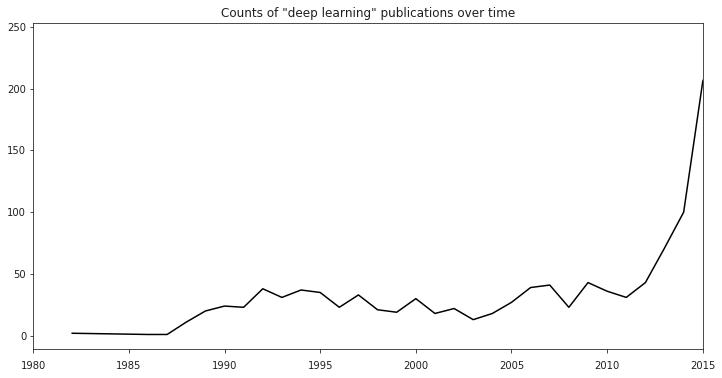

In [7]:
x = dict(dist).keys(); y = [];
for year, count in dict(dist).items():
    y.append(count)
    
plt.figure(figsize=(12,6))
plt.plot(x, y, color = 'k')
plt.xlim(1980, 2015)
plt.title('Counts of "deep learning" publications over time')
plt.show()

## Walk-through an example university

Let's try this procedure on University of Colorado, Boulder

In [8]:
place = 'University of Colorado, Boulder'

In [9]:
def get_hires_and_publications(place, keywords, asst_faculty):
    hires_and_publications = []
    for f in faculty_at_institution(place, asst_faculty):
        person = {"facultyName": f.facultyName, "phdRank": inst[f.phd()[0]]['pi'], "currentRank": inst[place]['pi']}

        person["start"] = 2020; person["end"] = 0;
        for job in f.faculty:
            if job['place'] == place and not (job['start_year'] is None):
                person["start"] = min(job['start_year'], person["start"])
                person["end"] = max(job['end_year'], person["end"])
    
        if person["end"] == 0:
            person["end"] = 2011
        if person["start"] == 2020:
            continue
    
        relevant_pubs = []
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                if any((pub['title'].lower().count(keyword) > 0) for keyword in keywords): #or relevant_venue:
                    #print(pub['title'])
                    relevant_pubs.append(pub['year'])
                        
        person["pubs"] = relevant_pubs
        person["phd_location"] = f.phd_location
        person["faculty_record"]= f
    
        hires_and_publications.append(person)
    
    return hires_and_publications

Let's plot the above data so we can better see when hires and publications occurred.

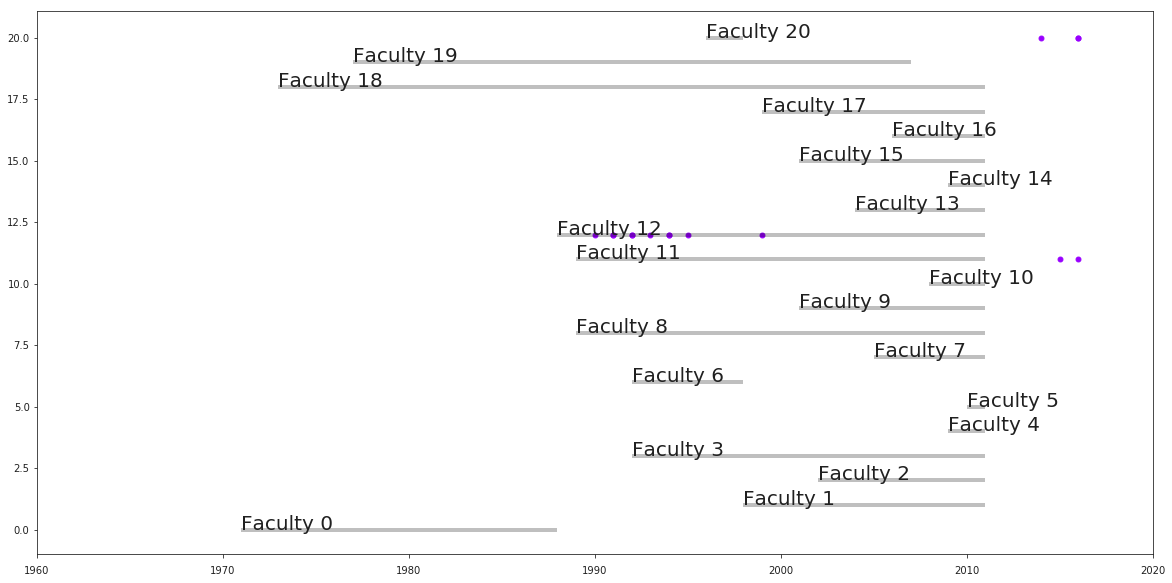

In [10]:
def plot_careers(place, keywords, asst_faculty):
    i = 0
    plt.figure(figsize=(20,10))
    for person in get_hires_and_publications(place, keywords, asst_faculty):
        #print person['facultyName']
        plt.plot([person["start"], person["end"]], [i, i], linewidth= 4, color = 'k', alpha = .25)
        plt.text(person["start"], i, "Faculty {0}".format(i), fontsize=20)
    
        if len(person['pubs']) > 0:
            plt.scatter(person['pubs'], [i]*len(person['pubs']), s = 24, color = [153.0/255.0, 0.0/255.0, 255.0/255.0])
        i += 1

    plt.xlim(1960, 2020)

plot_careers(place, deep_learning_keywords, asst_faculty)

Did the first deep-learning publication coincide with a faculty hiring event? Is the date of publication within two years of the author's hire? 

In [11]:
def find_infected_hire(place, keywords, asst_faculty):
    '''
    Returns None if no infected hire found, otherwise the first hire
    is returned as (person, year of infectious publication).
    '''
    candidates = []
    for person in get_hires_and_publications(place, keywords, asst_faculty):
        person_pubs = person["pubs"]
        # If we do not know the faculty member's start date, or they have no pubs
        if not person["start"] or len(person_pubs) == 0:
            continue
        
        # Consider the publications when the entry was a professor at the institution
        person_pubs = filter(lambda x: person["start"] <= x <= person["end"], person_pubs)
        if person_pubs:
            candidates.append((person, person_pubs))
    
    # If the university was never "infected"
    if not candidates:
        return None
    else:
        # return min(candidates, key=lambda xs: min(xs[1]))
        return candidates
        
print "\nWas a \"deep-learning\" researcher hired who might have led to the research area? {0}".format(find_infected_hire(place, deep_learning_keywords, asst_faculty))


Was a "deep-learning" researcher hired who might have led to the research area? [({'faculty_record': <faculty_hiring.parse.faculty_parser.faculty_record instance at 0x114375b00>, 'end': 2011, 'currentRank': 68.17, 'pubs': [1999, 1995, 1994, 1994, 1993, 1992, 1992, 1991, 1991, 1990], 'start': 1988, 'phd_location': 'UC San Diego', 'phdRank': 27.93, 'facultyName': 'Michael C. Mozer'}, [1999, 1995, 1994, 1994, 1993, 1992, 1992, 1991, 1991, 1990])]


In [12]:
def is_infected_hire(person, delta_t):
    return any([(pub - person[0]["start"]) <= delta_t for pub in person[0]["pubs"]])

In [13]:
print "Was the person who infected CU Boulder (Mike Mozer), infected by hiring? {0}".format(is_infected_hire(find_infected_hire(place, deep_learning_keywords, asst_faculty)[0], 2))

Was the person who infected CU Boulder (Mike Mozer), infected by hiring? True


## For all universities

In [14]:
def percent_has_relevant_prior_pubs(delta_t, keywords, asst_faculty):
    n_no_priors = 0
    n_yes_priors = 0
    total = 0
    # Go through every institution
    for place in inst.keys():
        if place == "UNKNOWN" or place == "All others":
            continue
            
        # Look for the faculty member which has infected the institution 
        infected_hires = find_infected_hire(place, keywords, asst_faculty)
        if not infected_hires:
            continue
        
        # Were they publishing on deep-learning before their hire date?
        for i, (candidate, min_pub) in enumerate(copy.copy(infected_hires)):
            if is_infected_hire([candidate], delta_t):
                infected_hires[i] = (candidate, [candidate['start']])

        # Check all the possible infections. Length of minima is greater than one
        # if there are multiple possible infections
        x = min(infected_hires, key=lambda xs: min(xs[1]))
        minima = [candidate for (candidate, min_pub) in infected_hires if min_pub == x[1]]
        
        # If any of them could have spread the infection due to hiring
        if any([not is_infected_hire([candidate], delta_t) for candidate in minima]):
            n_no_priors += 1
        else:
            n_yes_priors += 1
        total += 1
    
    print("Hires with no background in topic: {0}, Hires with background in topic: {1}, Total infected univesities: {2}".format(n_no_priors, n_yes_priors, total))
    return (float(n_no_priors)/total, float(n_yes_priors)/total)

In [15]:
topic_modeling_keywords = ["probabilistic latent semantic analysis", "plsa", "latent dirichlet allocation","latent semantic analysis", "latent semantic indexing", "topic model", "probabilistic topic modeling"]
incremental_keywords = ["incremental computation", "self-adjusting computation", "program derivative","dbtoaster", "incremental view", "partial evaluation", "incremental computing", "incrementally compute", "frtime", "adaptive functional programming", "delta ml", "haskell adaptive", "cornell synthesizer generator", "icedust", "adapton", "one-way dataflow constraints", "reactive computation", "differential dataflow", "jane street incremental", "incremental datalog", "incremental prolog", "incremental type checking", "self-adjusting"]
deep_learning_keywords = ["convolutional net", "convolutional neural net", "convolutional neural field", " rnn ", "deep learning", "deep-learning", "recursive neural net", "lstm", "long short-term memory", "generative adversarial network", "theano", "neural network", "deep belief net", "boltzmann machine", "convnet", "deep reinforcement learning", "deep neural network", " dnn ", " dnn-", "multilayer perceptron", "autoencoder", "auto-encoder", "activation function", "backprop", "back-prop", "ladder network", "bidirectional rnn", "bidirectional recurrent", "imagenet", "restricted boltzmann", "rmsprop", "convnet", "artificial neural network", "connectionist"]
quantum_computing_keywords = ['quantum information', 'non-locality', 'quantum comput', 'quantum teleport', 'quantum entangl', "bell's inequality", 'chsh inequality', "tsirelson's inequality", 'local hamiltonian', 'product state', 'mixed state', 'pure state', 'nonlocality', 'quantum tomography', 'unitary gate', 'quantum error correction', 'quantum algorithm', 'quantum complexity', 'quantum query complexity', 'quantum fourier transform', 'hidden subgroup problem', ' qma ', ' qcma ', ' bqp ', 'promisebqp', 'promise-bqp', 'quantum information', 'quantum communication', 'quantum channel', 'qubit', 'quantum code', 'quantum annealing', 'quantum supremacy', 'quantum ground state', 'linear optics', 'quantum lower bounds', 'quantum speed', 'boson sampling', 'classical simulation', 'povm', 'quantum advice', 'quantum cryptography', 'qip', 'quantum circuit', 'quantum walk', 'toffoli gate', 'hadamard gate', 'coset state', 'stabilizer state', 'quantum satisfiability', "simon's problem", "shor's algorithm", "grover's algorithm", 'fourier sampling', 'quantum gate', 'phase gate']
mechanism_design_keywords = ['algorithmic game theory', 'algorithmic economics', 'computational social choice', 'fair division', 'mechanism design', 'fair allocation', 'cost allocation']

print(">>> Deep Learning (n_keywords: {0})".format(len(deep_learning_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, deep_learning_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}\n".format(prob_yes_priors, prob_no_priors))
print(">>> Topic Modeling (n_keywords: {0})".format(len(topic_modeling_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, topic_modeling_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}\n".format(prob_yes_priors, prob_no_priors))
print(">>> Incremental Computation (n_keywords: {0})".format(len(incremental_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, incremental_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}\n".format(prob_yes_priors, prob_no_priors))
print(">>> Quantum Computing (n_keywords: {0})".format(len(quantum_computing_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, quantum_computing_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}\n".format(prob_yes_priors, prob_no_priors))
print(">>> Mechanism Design (n_keywords: {0})".format(len(mechanism_design_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, mechanism_design_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}".format(prob_yes_priors, prob_no_priors))

>>> Deep Learning (n_keywords: 34)
Hires with no background in topic: 77, Hires with background in topic: 42, Total infected univesities: 119
Fraction of infections due to hiring: 0.352941176471, not due to hiring: 0.647058823529

>>> Topic Modeling (n_keywords: 7)
Hires with no background in topic: 28, Hires with background in topic: 15, Total infected univesities: 43
Fraction of infections due to hiring: 0.348837209302, not due to hiring: 0.651162790698

>>> Incremental Computation (n_keywords: 23)
Hires with no background in topic: 17, Hires with background in topic: 11, Total infected univesities: 28
Fraction of infections due to hiring: 0.392857142857, not due to hiring: 0.607142857143

>>> Quantum Computing (n_keywords: 56)
Hires with no background in topic: 19, Hires with background in topic: 9, Total infected univesities: 28
Fraction of infections due to hiring: 0.321428571429, not due to hiring: 0.678571428571

>>> Mechanism Design (n_keywords: 7)
Hires with no background in t

In [16]:
def percent_has_prestige(delta_t, keywords, asst_faculty):
    n_came_from_prestige = 0
    n_moved_to_prestige = 0
    total = 0
    # Go through every institution
    for place in inst.keys():
        if place == "UNKNOWN" or place == "All others":
            continue
            
        # Look for the faculty member which has infected the institution 
        infected_hires = find_infected_hire(place, keywords, asst_faculty)
        if not infected_hires:
            continue
            
        # Were they publishing on deep-learning before their hire date?
        for i, (candidate, min_pub) in enumerate(copy.copy(infected_hires)):
            if is_infected_hire([candidate], delta_t):
                infected_hires[i] = (candidate, [candidate['start']])

        # Check all the possible infections. Length of minima is greater than one
        # if there are two possible infections
        x = min(infected_hires, key=lambda xs: min(xs[1]))
        minima = [candidate for (candidate, min_pub) in infected_hires if min_pub == x[1]]
        
        # If the transmission was via hiring, did they come from a more prestigious 
        # university than they are currently employed?
        if not any([not is_infected_hire([candidate], delta_t) for candidate in minima]):
            if all([candidate['phdRank'] < candidate['currentRank'] for candidate in minima if is_infected_hire([candidate], delta_t)]):
                n_came_from_prestige += 1
            else:
                n_moved_to_prestige += 1
            total += 1
    
    print("Hires who came from more prestigious background: {0}, came from less prestigious background: {1}, total: {2}".format(n_came_from_prestige, n_moved_to_prestige, total))
    return (float(n_came_from_prestige)/total, float(n_moved_to_prestige)/total)

In [17]:
print(">>> Deep Learning (n_keywords: {0})".format(len(deep_learning_keywords)))
(prob_came_from_prestige, prob_moved_to_prestige) = percent_has_prestige(2, deep_learning_keywords, asst_faculty)
print ""
print(">>> Topic Modeling (n_keywords: {0})".format(len(topic_modeling_keywords)))
(prob_came_from_prestige, prob_moved_to_prestige) = percent_has_prestige(2, topic_modeling_keywords, asst_faculty)
print ""
print(">>> Incremental Computation (n_keywords: {0})".format(len(incremental_keywords)))
(prob_came_from_prestige, prob_moved_to_prestige) = percent_has_prestige(2, incremental_keywords, asst_faculty)
print ""
print(">>> Quantum Computing (n_keywords: {0})".format(len(quantum_computing_keywords)))
(prob_came_from_prestige, prob_moved_to_prestige) = percent_has_prestige(2, quantum_computing_keywords, asst_faculty)
print ""
print(">>> Mechanism Design (n_keywords: {0})".format(len(mechanism_design_keywords)))
(prob_came_from_prestige, prob_moved_to_prestige) = percent_has_prestige(2, mechanism_design_keywords, asst_faculty)
print ""

>>> Deep Learning (n_keywords: 34)
Hires who came from more prestigious background: 34, came from less prestigious background: 8, total: 42

>>> Topic Modeling (n_keywords: 7)
Hires who came from more prestigious background: 12, came from less prestigious background: 3, total: 15

>>> Incremental Computation (n_keywords: 23)
Hires who came from more prestigious background: 9, came from less prestigious background: 2, total: 11

>>> Quantum Computing (n_keywords: 56)
Hires who came from more prestigious background: 9, came from less prestigious background: 0, total: 9

>>> Mechanism Design (n_keywords: 7)
Hires who came from more prestigious background: 7, came from less prestigious background: 4, total: 11



## Null Model

In [22]:
import copy
import random

asst_faculty_shuffled = copy.deepcopy(asst_faculty)
all_titles = []

for f in asst_faculty:
    if f.__contains__("dblp_pubs"):
        for pub in f.dblp_pubs:
            all_titles.append(pub['title'])

Generate our null model by shuffling the list of publications, and assigning them to faculty at random.

In [23]:
shuffled = copy.copy(all_titles)
fraction_dist = []
for i in range(100):
    np.random.shuffle(shuffled)
    for f in asst_faculty_shuffled:
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                pub['title'] = shuffled.pop()
    
    (prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, mechanism_design_keywords, asst_faculty_shuffled)
    
    print("({0}) Fraction of infections due to hiring: {1}, not due to hiring: {2}".format(len(fraction_dist), prob_yes_priors, prob_no_priors))
    fraction_dist.append(prob_yes_priors)
    shuffled = copy.copy(all_titles)

Hires with no background in topic: 60, Hires with background in topic: 22, Total infected univesities: 82
(0) Fraction of infections due to hiring: 0.268292682927, not due to hiring: 0.731707317073
Hires with no background in topic: 64, Hires with background in topic: 14, Total infected univesities: 78
(1) Fraction of infections due to hiring: 0.179487179487, not due to hiring: 0.820512820513
Hires with no background in topic: 57, Hires with background in topic: 22, Total infected univesities: 79
(2) Fraction of infections due to hiring: 0.278481012658, not due to hiring: 0.721518987342
Hires with no background in topic: 55, Hires with background in topic: 15, Total infected univesities: 70
(3) Fraction of infections due to hiring: 0.214285714286, not due to hiring: 0.785714285714
Hires with no background in topic: 54, Hires with background in topic: 18, Total infected univesities: 72
(4) Fraction of infections due to hiring: 0.25, not due to hiring: 0.75
Hires with no background in to

Hires with no background in topic: 50, Hires with background in topic: 14, Total infected univesities: 64
(43) Fraction of infections due to hiring: 0.21875, not due to hiring: 0.78125
Hires with no background in topic: 56, Hires with background in topic: 22, Total infected univesities: 78
(44) Fraction of infections due to hiring: 0.282051282051, not due to hiring: 0.717948717949
Hires with no background in topic: 65, Hires with background in topic: 14, Total infected univesities: 79
(45) Fraction of infections due to hiring: 0.177215189873, not due to hiring: 0.822784810127
Hires with no background in topic: 56, Hires with background in topic: 17, Total infected univesities: 73
(46) Fraction of infections due to hiring: 0.232876712329, not due to hiring: 0.767123287671
Hires with no background in topic: 53, Hires with background in topic: 21, Total infected univesities: 74
(47) Fraction of infections due to hiring: 0.283783783784, not due to hiring: 0.716216216216
Hires with no backg

Hires with no background in topic: 59, Hires with background in topic: 25, Total infected univesities: 84
(85) Fraction of infections due to hiring: 0.297619047619, not due to hiring: 0.702380952381
Hires with no background in topic: 57, Hires with background in topic: 18, Total infected univesities: 75
(86) Fraction of infections due to hiring: 0.24, not due to hiring: 0.76
Hires with no background in topic: 56, Hires with background in topic: 17, Total infected univesities: 73
(87) Fraction of infections due to hiring: 0.232876712329, not due to hiring: 0.767123287671
Hires with no background in topic: 61, Hires with background in topic: 19, Total infected univesities: 80
(88) Fraction of infections due to hiring: 0.2375, not due to hiring: 0.7625
Hires with no background in topic: 67, Hires with background in topic: 12, Total infected univesities: 79
(89) Fraction of infections due to hiring: 0.151898734177, not due to hiring: 0.848101265823
Hires with no background in topic: 67, Hi

(array([4.2875629 , 5.00215672, 6.07404745, 8.57512581, 6.78864127,
        3.57296909, 1.07189073, 0.        , 0.        , 0.35729691]),
 array([0.12857143, 0.15655936, 0.18454728, 0.21253521, 0.24052314,
        0.26851107, 0.29649899, 0.32448692, 0.35247485, 0.38046278,
        0.4084507 ]),
 <a list of 10 Patch objects>)

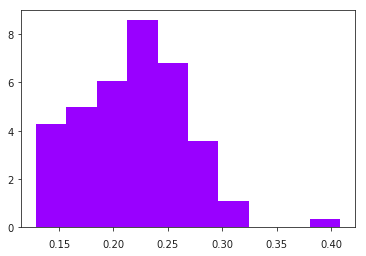

In [25]:
plt.hist(fraction_dist, density=True, color=[153.0/255.0, 0.0/255.0, 255.0/255.0])

In [26]:
print("What is the average infection due to hiring under model? {0}".format(sum(fraction_dist)/len(fraction_dist)))
print "How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([x for x in fraction_dist if x >= (0.478260869565)]) + 1)/(len(fraction_dist) + 1))

What is the average infection due to hiring under model? 0.219269432784
How many simulations resulting in a higher infection rate due to hiring? 0.00990099009901


In [22]:
# import cPickle
# with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/mechanism_design.p", "wb") as fp:
#     cPickle.dump(fraction_dist[:10000], fp)

## Load Cached Simulations of Null Model

The above simulation was run 10,000 times to generate the five pickles in this folder: `deep_learning.p`, `incremental_computing.p`, `topic_modeling.p`, etc. 

Let's load them in here. First, checking "incremental computation":

In [51]:
import cPickle
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/incremental_computing.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [52]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [53]:
real_infection_rate = 0.392857142857 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.19559785901
How many simulations resulting in a higher infection rate due to hiring? 0.001099890011


Next, checking "topic modeling":

In [54]:
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/topic_modeling.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [55]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [56]:
real_infection_rate = 0.348837209302 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.228818623072
How many simulations resulting in a higher infection rate due to hiring? 0.003599640036


Check "deep learning":

In [57]:
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/deep_learning.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [58]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [59]:
real_infection_rate = 0.352941176471 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.338476302871
How many simulations resulting in a higher infection rate due to hiring? 0.340865913409


Check "quantum computing":

In [60]:
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/quantum_computing.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [61]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [62]:
real_infection_rate = 0.321428571429 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.221998671632
How many simulations resulting in a higher infection rate due to hiring? 0.013898610139


Finally check "mechanism design": 

In [63]:
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/mechanism_design.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [64]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [65]:
real_infection_rate = 0.478260869565 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.214939568762
How many simulations resulting in a higher infection rate due to hiring? 9.99900009999e-05


## Transmission diagrams

In [66]:
import matplotlib.patches as patches
style = "Simple,tail_width=0.5,head_width=7,head_length=8"
ACCENT_COLOR_1 = np.array([127, 37, 251]) / 255.
kw = dict(arrowstyle=style)

def get_infection_timeline(keywords):
    delta_t = 2
    infection_timeline = {}

    for place in inst:
        year = np.inf  # Initialize to inf (never infected)
        hiring_inf = None
        person = None

        # Get person with first relevant publication 
        infected_hires = find_infected_hire(place, keywords, asst_faculty)
        if infected_hires:
            # Were they publishing on deep-learning before their hire date?
            for i, (candidate, min_pub) in enumerate(copy.copy(infected_hires)):
                if is_infected_hire([candidate], delta_t):
                    infected_hires[i] = (candidate, [candidate['start']])

            # Check all the possible infections. Length of minima is greater than one
            # if there are multiple possible infections
            x = min(infected_hires, key=lambda xs: min(xs[1]))
            minima = [(candidate, min_pub) for (candidate, min_pub) in infected_hires if min_pub == x[1]]

            # If an idea was not transmitted to an institution
            if any([not is_infected_hire([candidate], delta_t) for (candidate, min_pub) in minima]):
                 year = np.min([min_pub for (_, min_pub) in minima])
            else:
                # If any of them could have spread the infection due to hiring, choose one among
                # the equally likely candidates 
                index = np.random.choice(len(minima), 1)[0]
                year = minima[index][0]["start"]
                hiring_inf = minima[index][0]["phd_location"]
                person = minima[index][0]
                
        # Year of infection, infecting dept (if caused by hiring, else None), person
        infection_timeline[place] = (year, hiring_inf, person)
        
    return infection_timeline

# Build timelines
deep_learning_timeline = get_infection_timeline(deep_learning_keywords)
topic_modeling_timeline = get_infection_timeline(topic_modeling_keywords)
incremental_timeline = get_infection_timeline(incremental_keywords)

'''
Examples: 
print(deep_learning_timeline["MIT"])  # Year when MIT was infected and by whom.
print(deep_learning_timeline["UCLA"]) # UCLA was a spontaneous infection.
print(deep_learning_timeline["University of Nebraska, Lincoln"])  # UNL hasn't a deep learner. 

Outputs:
(1988, 'UC San Diego', {'faculty_record': <faculty_hiring.parse.faculty_parser.faculty_record instance at 0x110e26dd0>, 'end': 1998, 'pubs': [2016, 2015, 2015, 2013, 2000, 1998, 1997, 1996, 1993, 1993, 1991, 1990], 'start': 1988, 'phd_location': 'UC San Diego', 'facultyName': 'Michael Jordan'})
(1993, None, None)
(inf, None, None)
'''

def save_timeline(filename, timeline):
    with open(filename, 'w') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow(["target_inst", "target_inst_prestige", "target_inst_rank", "year_adopted", "source_inst"])
        ranks = sorted([inst[place]['pi'] for place in inst])
        for place in inst:
            x = deep_learning_timeline[place]
            writer.writerow([place, inst[place]['pi'], ranks.index(inst[place]['pi']), x[0], x[1]])

save_timeline('deep_learning_timeline.tsv', deep_learning_timeline)
save_timeline('topic_modeling_timeline.tsv', topic_modeling_timeline)
save_timeline('incremental_timeline.tsv', incremental_timeline)

In [67]:
def make_year_snapshot(ax, timeline, limit=206, year=2000, prev_year=-np.inf, verbose=False, name=None):
    ax.set_aspect(1)
    sel_places = [p[1] for p in sorted([(inst[place]['pi'], place) for place in inst])][:limit]
    deg_places = np.pi/2 - np.linspace(0, 2*np.pi, limit, endpoint=False)
    r = 1
    x = r*np.cos(deg_places)
    y = r*np.sin(deg_places)
    r2 = 0.955
    x2 = r2*np.cos(deg_places)
    y2 = r2*np.sin(deg_places)
    ax.scatter(x, y, edgecolor='None', color=LIGHT_COLOR, s=5)
    arrows = []
    new_infections = 0
    new_spotaneous = 0
    
    for i, place in enumerate(sel_places): 
        if timeline[place][0] < year:
            if timeline[place][1] is None:
                if timeline[place][0] >= prev_year:
                    new_spotaneous += 1
                edgecolor = DARK_COLOR
                color = 'w'
                s = 50
            else:
                color = ACCENT_COLOR_1
                edgecolor = 'w'
                s = 100
                if timeline[place][1] in sel_places and timeline[place][0] >= prev_year:
                    new_infections += 1
                    if verbose: print(timeline[place][1])
                    org = sel_places.index(timeline[place][1])
                    
                    #radius = .8 - (np.abs(deg_places[org]-deg_places[i]) / (np.pi))
                    radius = -np.log((0.01+np.abs(deg_places[org]-deg_places[i]) / (np.pi)))
                    p1 = (x[org],y[org])
                    p2 = (x2[i],y2[i])
                    
                    if deg_places[i] > deg_places[org] and deg_places[i] - deg_places[org] < .9*np.pi: 
                        radius *= -1
                        arrows.append(patches.FancyArrowPatch(p1, p2, zorder=-10, 
                            connectionstyle="arc3,rad=%f" % (radius), color='k', **kw))
                    else:
                        arrows.append(patches.FancyArrowPatch(p1, p2, zorder=-10, 
                            connectionstyle="arc3,rad=%f" % (radius), color='k', **kw))
                     
            ax.scatter(x[i], y[i], edgecolor=edgecolor, color=color, s=s)
            
    for a in arrows:
        ax.add_patch(a)
        
    ax.axis('off')
    
    opts = {'y':0.975, 'fontsize':LABEL_SIZE+2}
    
    if prev_year > -np.inf:
        ax.set_title('%d to %d' % (int(prev_year), int(year)-1), **opts)
    else:
        ax.set_title('Up to %d' % (int(year)), **opts)
        
    xnudge = .075
    xloc=1.125
    ax.scatter(xloc, -.75, edgecolor='w', color=ACCENT_COLOR_1, s=100)    
    ax.text(xloc-xnudge, -.75, "+%d" % new_infections, color=ACCENT_COLOR_1, fontsize=LABEL_SIZE+1, ha='right', va='center')
    
    ax.scatter(xloc, -.925, color='w', edgecolor=DARK_COLOR, s=50)    
    ax.text(xloc-xnudge, -.925, "+%d" % new_spotaneous, color=DARK_COLOR, fontsize=LABEL_SIZE+1, ha='right', va='center')
        
    if name is not None:
        ax.text(-r*1.25, 0, name, rotation=90, fontsize=LABEL_SIZE+4, ha='center', va='center', rotation_mode='anchor')

In [68]:
import numpy as np
from matplotlib import rcParams

# Constants
SINGLE_FIG_SIZE = (6,4)
BAR_WIDTH = 0.6
TICK_SIZE = 15
XLABEL_PAD = 10
LABEL_SIZE = 14
TITLE_SIZE = 16
LEGEND_SIZE = 12
LINE_WIDTH = 2
LIGHT_COLOR = '0.8'
LIGHT_COLOR_V = np.array([float(LIGHT_COLOR) for i in xrange(3)])
DARK_COLOR = '0.4'
DARK_COLOR_V = np.array([float(DARK_COLOR) for i in xrange(3)])
ALMOST_BLACK = '0.125'
ALMOST_BLACK_V = np.array([float(ALMOST_BLACK) for i in xrange(3)])
# ACCENT_COLOR_1 = np.array([255., 145., 48.]) / 255.

# Configuration
#rcParams['text.usetex'] = True #Let TeX do the typsetting
rcParams['pdf.use14corefonts'] = True
rcParams['ps.useafm'] = True
rcParams['text.latex.preamble'] = [r'\usepackage{helvet}', 
#r'\usepackage[scale=1.0]{tgheros}',
r'\usepackage[frenchmath]{newtxsf}',
r'\renewcommand{\familydefault}{\sfdefault}'
r'\usepackage{mathastext}'] #Force sans-serif math mode (for axes labels)
#rcParams['font.family'] = 'sans-serif' # ... for regular text
rcParams['font.sans-serif'] = ['Helvetica Neue', 'HelveticaNeue', 'Helvetica'] #, Avant Garde, Computer Modern Sans serif' # Choose a nice font here
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['text.color'] = ALMOST_BLACK
rcParams['axes.unicode_minus'] = False

rcParams['xtick.major.pad'] = '8'
rcParams['axes.edgecolor']  = ALMOST_BLACK
rcParams['axes.labelcolor'] = ALMOST_BLACK

rcParams['lines.color']     = ALMOST_BLACK
rcParams['xtick.color']     = ALMOST_BLACK
rcParams['ytick.color']     = ALMOST_BLACK
rcParams['text.color']      = ALMOST_BLACK
rcParams['lines.solid_capstyle'] = 'butt'
rcParams['text.usetex'] = True

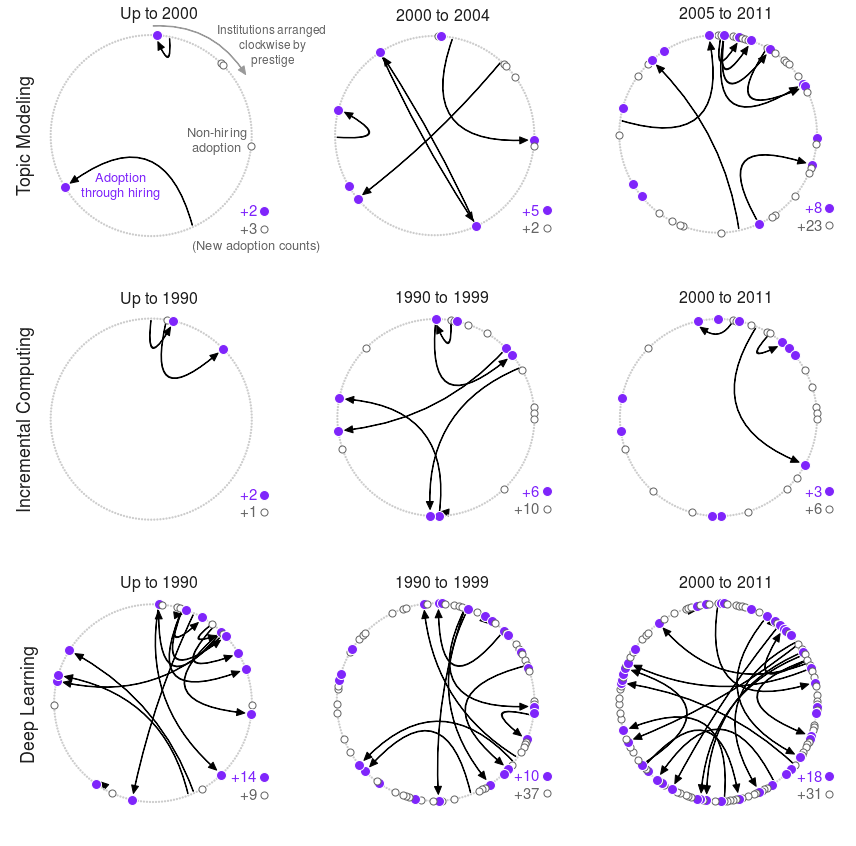

In [69]:
fig, ax_grid = plt.subplots(3,3,figsize=(12,12))

times = [("Topic Modeling", topic_modeling_timeline), 
         ("Incremental Computing", incremental_timeline), 
         ("Deep Learning", deep_learning_timeline)]

years = [[2000, 2005, 2012],
         [1990, 2000, 2012],
         [1990, 2000, 2012],]

for j, axs in enumerate(ax_grid):
    title, timeline = times[j]
    for i, year in enumerate(years[j]):
        if i == 0:
            prev_year = -np.inf
            label = title
        else:
            prev_year = years[j][i-1]
            label = None
            
        make_year_snapshot(axs[i], timeline, year=year, prev_year=prev_year, name=label)
        
ax_grid[0][0].text(-0.3, -.5, 'Adoption\nthrough hiring', ha='center', va='center', fontsize=LABEL_SIZE-1, color=ACCENT_COLOR_1)
ax_grid[0][0].text(0.65, -.05, 'Non-hiring\nadoption', ha='center', va='center', fontsize=LABEL_SIZE-1, color=DARK_COLOR)
ax_grid[0][0].text(1.05, -1.1, '(New adoption counts)', ha='center', va='center', fontsize=LABEL_SIZE-1, color=DARK_COLOR)

yn = 0.01
ax_grid[0][0].add_patch(patches.FancyArrowPatch((0, 1.1-yn), (.95,.6-yn), zorder=-10,
                            connectionstyle="arc3,rad=-.3", color='0.6', **kw))
ax_grid[0][0].text(1.2, .9, 'Institutions arranged\nclockwise by\nprestige', ha='center', va='center', fontsize=LABEL_SIZE-2, color=DARK_COLOR)

    
plt.tight_layout()
plt.savefig('../results/timelines.eps')
plt.show()